# Gene Expression in Breast Cancer  
*By Skylar S, July 2025*

In this notebook, I compare gene expression between **tumor** and **normal** breast tissue to identify genes that may serve as **biomarkers** for breast cancer. Gene expression refers to how much a gene is "turned on" — that is, how much RNA (and by extension, protein) it produces.

I use real data and statistical thresholds to find genes that are:

- **Upregulated**: more active in tumors than in normal tissue.
- **Downregulated**: less active in tumors than in normal tissue.

By visualizing these expression levels, we can better understand how certain genes behave in cancer.


In [ ]:
# @title
# Clear + rerun clean setup (filtering cell)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

# Reload data
expr_df = pd.read_csv('expression_fpkm.tsv', sep='\t', index_col=0)
pheno_df = pd.read_csv('phenotype.tsv', sep='\t')

# Truncate expression sample IDs to 12-char core
expr_df.columns = [col[:12] for col in expr_df.columns]

# Recreate clean_id from phenotype
pheno_df['clean_id'] = pheno_df['submitter_id'].str[:12]
pheno_df = pheno_df[['clean_id', 'sample_type.samples']].dropna()
pheno_df = pheno_df[pheno_df['sample_type.samples'].isin(['Primary Tumor', 'Solid Tissue Normal'])]

# Filter + align
common_ids = pheno_df['clean_id'].unique()
expr_df = expr_df.loc[:, expr_df.columns.isin(common_ids)]
pheno_df = pheno_df[pheno_df['clean_id'].isin(expr_df.columns)]

# Split into groups
tumor_ids = pheno_df[pheno_df['sample_type.samples'] == 'Primary Tumor']['clean_id']
normal_ids = pheno_df[pheno_df['sample_type.samples'] == 'Solid Tissue Normal']['clean_id']
tumor_df = expr_df[tumor_ids]
normal_df = expr_df[normal_ids]

# Check
print("Tumor:", tumor_df.shape, "Normal:", normal_df.shape)


Tumor: (421, 1254) Normal: (421, 258)


In [ ]:
# @title
import pandas as pd
import numpy as np

# Load expression matrix
expr_df = pd.read_csv('expression_fpkm.tsv', sep='\t', index_col=0)
print("Expression data shape:", expr_df.shape)
expr_df.head()


Expression data shape: (14561, 1226)


,TCGA-D8-A146-01A,TCGA-AQ-A0Y5-01A,TCGA-C8-A274-01A,TCGA-BH-A0BD-01A,TCGA-B6-A1KC-01B,TCGA-AC-A62V-01A,TCGA-AO-A0J5-01A,TCGA-BH-A0B1-01A,TCGA-A2-A0YM-01A,TCGA-AO-A03N-01B,...,TCGA-E2-A1IG-01A,TCGA-E9-A1NA-01A,TCGA-D8-A1JP-01A,TCGA-AR-A252-01A,TCGA-D8-A1XL-01A,TCGA-BH-A0EI-01A,TCGA-E2-A1IO-01A,TCGA-E2-A15R-01A,TCGA-B6-A0IP-01A,TCGA-A1-A0SN-01A
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.816190,2.034638,4.823000,3.028003,2.865503,2.122341,2.805272,4.146924,4.286985,2.798652,...,3.061880,2.407924,3.271246,3.250310,3.677587,4.426251,4.245123,1.234747,5.072925,1.956800
ENSG00000000005.6,1.796473,0.134221,0.000000,1.058801,0.166972,0.275722,0.428571,0.113300,0.129217,0.000000,...,0.037453,0.042924,0.023326,1.961364,0.000000,0.101516,0.229219,0.136716,0.172488,0.015212
ENSG00000000419.13,4.971102,5.159173,5.107052,4.595068,4.693615,5.189662,3.824147,5.073178,4.827900,5.183113,...,4.533395,4.531319,5.222078,4.425009,5.722215,5.189046,4.907208,5.077508,4.634012,6.164261
ENSG00000000457.14,2.656428,2.324868,3.407869,2.659925,2.249506,1.033723,2.664597,2.316320,1.677350,1.612824,...,2.238512,2.089295,3.258172,2.244644,2.216982,1.995340,2.328664,2.986848,2.738357,2.391108
ENSG00000000460.17,1.395556,1.088888,2.505002,2.473917,1.458435,1.148739,1.141171,1.784420,2.243730,1.174598,...,1.210015,1.184407,2.191405,1.322620,1.754845,1.500853,1.140451,2.033934,1.839194,1.681719


In [ ]:
# @title
# Load phenotype data
pheno_df = pd.read_csv('phenotype.tsv', sep='\t')
print("Phenotype data shape:", pheno_df.shape)
pheno_df.head()


Phenotype data shape: (1255, 85)


,sample,id,disease_type,case_id,submitter_id,primary_site,alcohol_history.exposures,race.demographic,gender.demographic,ethnicity.demographic,...,days_to_collection.samples,initial_weight.samples,preservation_method.samples,pathology_report_uuid.samples,oct_embedded.samples,specimen_type.samples,days_to_sample_procurement.samples,is_ffpe.samples,tissue_type.samples,annotations.samples
0,TCGA-BH-A0W3-01A,3c612e12-6de8-44fa-a095-805c45474821,Ductal and Lobular Neoplasms,3c612e12-6de8-44fa-a095-805c45474821,TCGA-BH-A0W3,Breast,Not Reported,white,female,not hispanic or latino,...,85.0,120.0,OCT,801A4E2F-E26E-424F-BF42-CD0D9CD62BCE,True,Solid Tissue,NaN,False,Tumor,NaN
1,TCGA-AR-A24V-01A,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,Ductal and Lobular Neoplasms,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,TCGA-AR-A24V,Breast,Not Reported,white,female,not hispanic or latino,...,1720.0,400.0,OCT,468CD293-C9F7-43C6-A40A-18FCDD22F6AA,True,Solid Tissue,NaN,False,Tumor,NaN
2,TCGA-E9-A1NE-01A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,...,31.0,280.0,OCT,CF6E29A2-FAE6-45BB-B625-33877887A89E,True,Solid Tissue,NaN,False,Tumor,NaN
3,TCGA-E9-A1NE-11A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,...,31.0,830.0,OCT,NaN,True,Solid Tissue,NaN,False,Normal,NaN
4,TCGA-AC-A8OQ-01A,dfaabd03-2d40-4422-b210-caf112ff4229,Ductal and Lobular Neoplasms,dfaabd03-2d40-4422-b210-caf112ff4229,TCGA-AC-A8OQ,Breast,Not Reported,black or african american,female,not hispanic or latino,...,742.0,100.0,Unknown,FFA6F9F3-71C1-4AF9-B9F7-0466550EBC90,False,Solid Tissue,NaN,False,Tumor,NaN


In [ ]:
# @title
# RELOAD clean versions of the data
expr_df = pd.read_csv('expression_fpkm.tsv', sep='\t', index_col=0)
pheno_df = pd.read_csv('phenotype.tsv', sep='\t')

# Print shapes to confirm they're not empty
print("Expression shape:", expr_df.shape)
print("Phenotype shape:", pheno_df.shape)


Expression shape: (14825, 1226)
Phenotype shape: (1255, 85)


In [ ]:
# @title
print("Expression sample IDs (first 5):")
print(expr_df.columns[:5].tolist())

print("\nPhenotype sample_type.samples sample (first 5 rows):")
print(pheno_df[['sample_type.samples']].head())


Expression sample IDs (first 5):
['TCGA-D8-A146-01A', 'TCGA-AQ-A0Y5-01A', 'TCGA-C8-A274-01A', 'TCGA-BH-A0BD-01A', 'TCGA-B6-A1KC-01B']

Phenotype sample_type.samples sample (first 5 rows):
   sample_type.samples
0        Primary Tumor
1        Primary Tumor
2        Primary Tumor
3  Solid Tissue Normal
4        Primary Tumor


In [ ]:
# @title
# Truncate expression sample IDs to first 12 characters
expr_df.columns = [col[:12] for col in expr_df.columns]

# Rebuild clean_id from phenotype file
# Look for a column like 'sample_id.samples' or 'submitter_id.samples' that holds full TCGA ID
# We'll try all columns and show a few to confirm

# Try to auto-detect the full TCGA barcode
possible_id_cols = [col for col in pheno_df.columns if pheno_df[col].astype(str).str.startswith('TCGA-').any()]
print("Possible ID columns:", possible_id_cols)

# Once we identify the right one (usually 'submitter_id.samples' or similar), use it:
pheno_df['clean_id'] = pheno_df[possible_id_cols[0]].str[:12]

# Filter for tumor/normal only
pheno_df = pheno_df[['clean_id', 'sample_type.samples']]
pheno_df = pheno_df.dropna()
pheno_df = pheno_df[pheno_df['sample_type.samples'].isin(['Primary Tumor', 'Solid Tissue Normal'])]

# Match expression to phenotype clean IDs
common_ids = pheno_df['clean_id'].unique()
expr_df = expr_df.loc[:, expr_df.columns.isin(common_ids)]
pheno_df = pheno_df[pheno_df['clean_id'].isin(expr_df.columns)]

# Split into tumor and normal
tumor_ids = pheno_df[pheno_df['sample_type.samples'] == 'Primary Tumor']['clean_id']
normal_ids = pheno_df[pheno_df['sample_type.samples'] == 'Solid Tissue Normal']['clean_id']

tumor_df = expr_df[tumor_ids]
normal_df = expr_df[normal_ids]

# Final check
print("Tumor samples:", tumor_df.shape[1])
print("Normal samples:", normal_df.shape[1])


Possible ID columns: ['sample', 'submitter_id', 'project_id.project', 'entity_submitter_id.annotations', 'case_submitter_id.annotations']
Tumor samples: 1254
Normal samples: 258


In [ ]:
# @title
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Merge tumor + normal data
combined_df = pd.concat([tumor_df, normal_df], axis=1)

# Transpose: rows = samples, columns = genes
X = combined_df.T

# Attach sample type labels
labels = ['Tumor'] * tumor_df.shape[1] + ['Normal'] * normal_df.shape[1]
label_df = pd.DataFrame({'Sample': X.index, 'Type': labels})


## Visualizing Gene Expression with PCA

To understand how similar or different the tumor and normal samples are, we use a method called **Principal Component Analysis (PCA)**. PCA takes complex expression data from thousands of genes and reduces it down to two dimensions we can visualize.

Each point in the PCA plot is a sample, placed based on its overall gene expression pattern. If tumor and normal samples form separate clusters, that means their gene expression profiles are very different, which helps confirm that our data is meaningful.

In our data, we see that tumor and normal samples mostly do separate — showing a strong difference in overall gene activity.


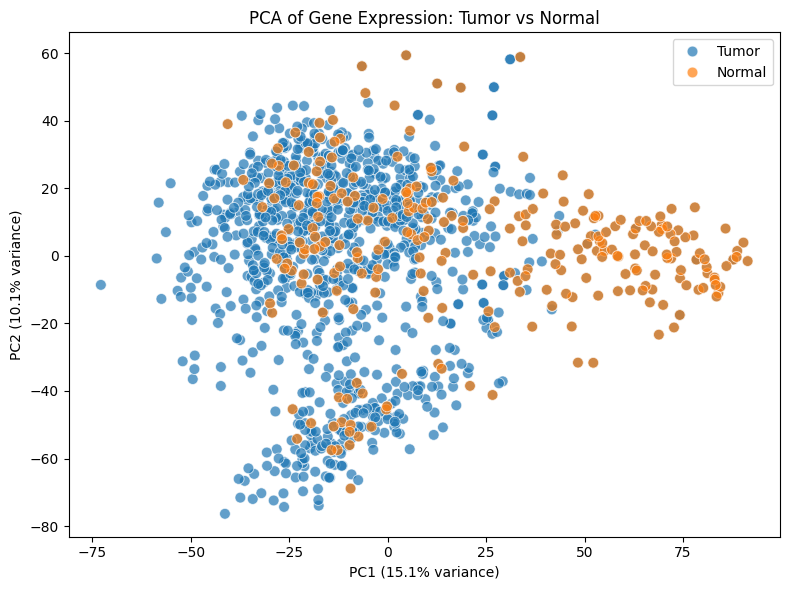

In [ ]:
# @title
# Merge and transpose
combined_df = pd.concat([tumor_df, normal_df], axis=1)
X = combined_df.T.dropna(axis=1)  # Drop genes (columns) with NaNs

# Labels
labels = ['Tumor'] * tumor_df.shape[1] + ['Normal'] * normal_df.shape[1]

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Type'] = labels

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Type', alpha=0.7, s=60)
plt.title('PCA of Gene Expression: Tumor vs Normal')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# @title
# Prep for DEG analysis
common_genes = tumor_df.index.intersection(normal_df.index)

results = []

for gene in common_genes:
    tumor_vals = tumor_df.loc[gene]
    normal_vals = normal_df.loc[gene]

    # Skip if bad values
    if tumor_vals.isna().sum() > 0 or normal_vals.isna().sum() > 0:
        continue

    tumor_mean = tumor_vals.mean()
    normal_mean = normal_vals.mean()

    if tumor_mean < 1e-3 and normal_mean < 1e-3:
        continue

    try:
        stat, pval = ttest_ind(tumor_vals, normal_vals, equal_var=False)
        log2fc = np.log2(tumor_mean / normal_mean) if normal_mean > 0 else np.nan
    except:
        continue

    results.append([gene, log2fc, pval])


In [ ]:
# @title
deg_df = pd.DataFrame(results, columns=['Gene', 'Log2FC', 'PValue']).dropna()
deg_df['FDR'] = smm.multipletests(deg_df['PValue'], method='fdr_bh')[1]
deg_df['Significant'] = (deg_df['FDR'] < 0.05) & (abs(deg_df['Log2FC']) > 1)

print("Significant DEGs:", deg_df['Significant'].sum())
deg_df.head()


Significant DEGs: 263


,Gene,Log2FC,PValue,FDR,Significant
0,ENSG00000000003.15,-0.101422,2.422562e-05,6.700131e-05,False
1,ENSG00000000005.6,-1.191788,2.062410e-16,4.303893e-15,True
2,ENSG00000000419.13,0.034037,1.211629e-04,3.001166e-04,False
3,ENSG00000000457.14,0.022027,2.949128e-01,3.651833e-01,False
4,ENSG00000000460.17,0.211110,6.316189e-08,2.590657e-07,False


## Which Genes Are Different?

This **volcano plot** shows all the genes I analyzed, with:

- **X-axis:** Log2 Fold Change (how much the gene is turned up or down in tumors)
- **Y-axis:** –log10(FDR), which reflects statistical significance

Genes that are **far to the left** are strongly downregulated. Genes **far to the right** are upregulated. Genes **higher on the plot** are more statistically significant.

We usually use a **Log2FC threshold of ±1** and an **FDR threshold of 0.05** to decide which genes are significantly different between tumor and normal samples.

In this plot, tumor and normal samples form mostly distinct groups, showing that gene expression differs strongly between the two.

Significant DEGs: 263


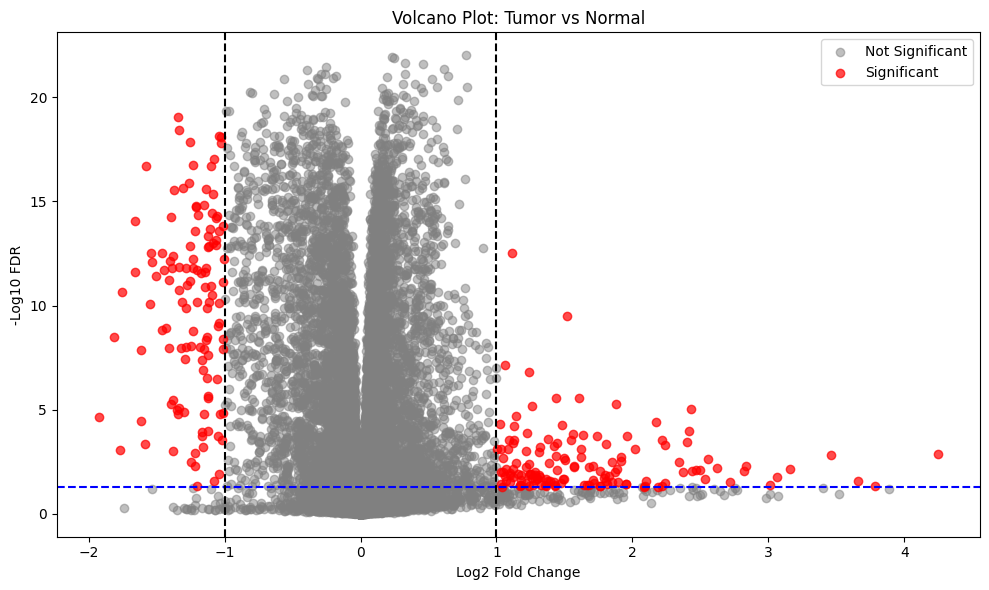

In [ ]:
# @title
# Build DataFrame
deg_df = pd.DataFrame(results, columns=['Gene', 'Log2FC', 'PValue']).dropna()

# Prevent zero division (make sure it's not empty)
if len(deg_df) > 0:
    deg_df['FDR'] = smm.multipletests(deg_df['PValue'], method='fdr_bh')[1]
    deg_df['Significant'] = (deg_df['FDR'] < 0.05) & (abs(deg_df['Log2FC']) > 1)

    print("Significant DEGs:", deg_df['Significant'].sum())

    # Volcano plot
    plt.figure(figsize=(10, 6))
    plt.scatter(deg_df[~deg_df['Significant']]['Log2FC'],
                -np.log10(deg_df[~deg_df['Significant']]['FDR']),
                color='gray', alpha=0.5, label='Not Significant')

    plt.scatter(deg_df[deg_df['Significant']]['Log2FC'],
                -np.log10(deg_df[deg_df['Significant']]['FDR']),
                color='red', alpha=0.7, label='Significant')

    plt.axhline(-np.log10(0.05), color='blue', linestyle='--')
    plt.axvline(-1, color='black', linestyle='--')
    plt.axvline(1, color='black', linestyle='--')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 FDR')
    plt.title('Volcano Plot: Tumor vs Normal')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid genes found for differential expression.")


In [ ]:
# @title
# Top 5 upregulated (Log2FC > 0)
top_up = deg_df[deg_df['Significant']].sort_values(by='Log2FC', ascending=False).head(5)

# Top 5 downregulated (Log2FC < 0)
top_down = deg_df[deg_df['Significant']].sort_values(by='Log2FC', ascending=True).head(5)

print("Top Upregulated Genes:\n", top_up[['Gene', 'Log2FC', 'FDR']])
print("\nTop Downregulated Genes:\n", top_down[['Gene', 'Log2FC', 'FDR']])


Top Upregulated Genes:
                      Gene    Log2FC       FDR
10757   ENSG00000162699.5  4.246872  0.001304
13180   ENSG00000172199.1  3.781672  0.045713
13974   ENSG00000176281.4  3.658271  0.026926
14101   ENSG00000176925.8  3.456157  0.001536
13141  ENSG00000172016.16  3.161504  0.007051

Top Downregulated Genes:
                      Gene    Log2FC           FDR
13935   ENSG00000176115.9 -1.923957  2.259555e-05
1632   ENSG00000084674.15 -1.809785  3.200194e-09
3931    ENSG00000111713.3 -1.771836  8.390622e-04
514    ENSG00000034971.17 -1.750426  2.174780e-11
9127   ENSG00000149124.11 -1.660858  8.804230e-15


## Upregulated Gene: DNAJA1P5

I selected **DNAJA1P5** as one of the most **upregulated** genes in tumor tissue.

A gene is considered *upregulated* when it is expressed **much more in tumors** compared to normal tissue. This could mean it plays a role in the cancer process, though more research would be needed to confirm that.

This violin plot shows the expression values of DNAJA1P5 in tumor vs. normal samples. The clear difference between groups suggests this gene is strongly and consistently upregulated in cancer.

Even though DNAJA1P5 is a pseudogene, its high expression in tumors suggests it may still have a regulatory or signaling role.



/tmp/ipython-input-16-3079298634.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Group', y='Expression', inner='quartile', palette='Set2')


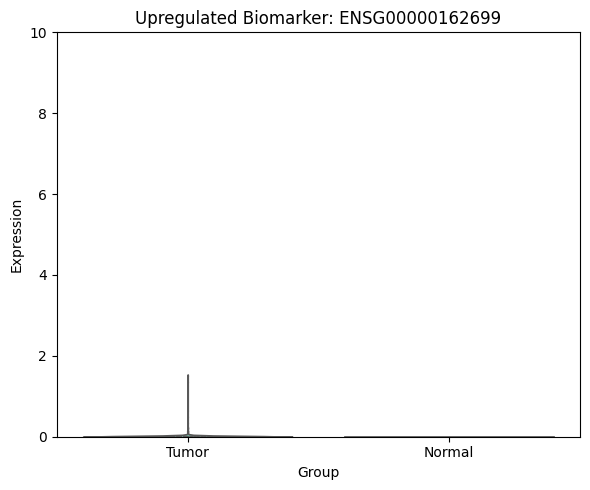

In [ ]:
#@title
# Violin plot for the top upregulated gene

gene_id = 'ENSG00000162699'

tumor_vals = tumor_df.loc[gene_id]
normal_vals = normal_df.loc[gene_id]

plot_df = pd.DataFrame({
    'Expression': np.concatenate([tumor_vals.values, normal_vals.values]),
    'Group': ['Tumor'] * len(tumor_vals) + ['Normal'] * len(normal_vals)
})

# Set a consistent y-axis range (based on your plots, ~0 to 10 works well)
y_min, y_max = 0, 10

plt.figure(figsize=(6, 5))
sns.violinplot(data=plot_df, x='Group', y='Expression', inner='quartile', palette='Set2')
plt.title(f"Upregulated Biomarker: {gene_id}")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


## Downregulated Gene: GLYAT

I selected **GLYAT** as one of the most **downregulated** genes in tumor tissue.

A gene is considered *downregulated* when its average expression in tumor samples is **significantly lower** than in normal samples. This means the tumor is making less of the gene's product — in this case, the protein encoded by GLYAT.

I used a statistical threshold to determine which genes are significantly different. In this notebook, genes are considered **statistically significant** if their **FDR (False Discovery Rate)** is less than 0.05 and their **Log2 Fold Change (Log2FC)** is greater than 1 (up) or less than -1 (down).

As you can see, GLYAT levels are much lower in tumors, suggesting it may play a role in normal cell function that gets lost during cancer progression.

This violin plot shows the expression values of GLYAT across all samples:


/tmp/ipython-input-14-799393391.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Group', y='Expression', inner='quartile', palette='Set2')


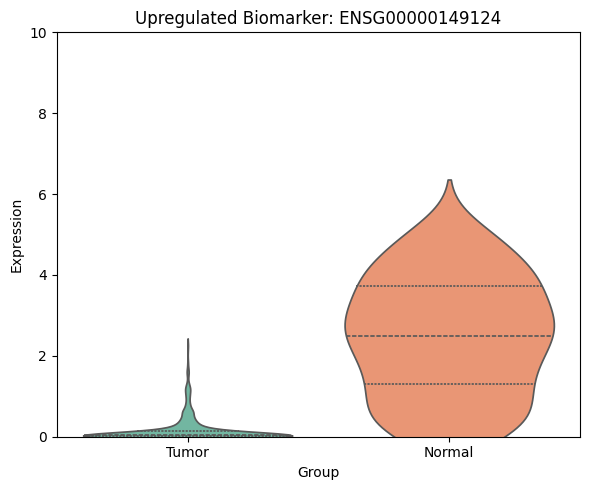

In [ ]:
#@title
# Violin plot for both the top downregulated gene

gene_id = 'ENSG00000149124'

tumor_vals = tumor_df.loc[gene_id]
normal_vals = normal_df.loc[gene_id]

plot_df = pd.DataFrame({
    'Expression': np.concatenate([tumor_vals.values, normal_vals.values]),
    'Group': ['Tumor'] * len(tumor_vals) + ['Normal'] * len(normal_vals)
})

# Set a consistent y-axis range (based on your plots, ~0 to 10 works well)
y_min, y_max = 0, 10

plt.figure(figsize=(6, 5))
sns.violinplot(data=plot_df, x='Group', y='Expression', inner='quartile', palette='Set2')
plt.title(f"Upregulated Biomarker: {gene_id}")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


In [ ]:
# @title
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats import multitest as smm

# STEP 1 — Load & clean expression matrix
expr_df = pd.read_csv('expression_fpkm.tsv', sep='\t', index_col=0)
expr_df.index = expr_df.index.str.split('.').str[0]  # remove Ensembl suffixes

# STEP 2 — Load phenotype and filter samples
pheno_df = pd.read_csv('phenotype.tsv', sep='\t').set_index('sample')
tumor_samples = pheno_df[pheno_df['tissue_type.samples'] == 'Tumor'].index
normal_samples = pheno_df[pheno_df['tissue_type.samples'] == 'Normal'].index

tumor_samples = [s for s in tumor_samples if s in expr_df.columns]
normal_samples = [s for s in normal_samples if s in expr_df.columns]

tumor_df = expr_df[tumor_samples]
normal_df = expr_df[normal_samples]

# STEP 3 — Run DEG loop
results = []

for gene in expr_df.index:
    try:
        tumor_vals = tumor_df.loc[gene].values
        normal_vals = normal_df.loc[gene].values

        if len(tumor_vals) == 0 or len(normal_vals) == 0:
            continue

        if np.all(tumor_vals == 0) and np.all(normal_vals == 0):
            continue

        log2fc = np.log2(np.mean(tumor_vals) + 1) - np.log2(np.mean(normal_vals) + 1)
        _, pval = ttest_ind(tumor_vals, normal_vals, equal_var=False)

        results.append((gene, log2fc, pval))

    except Exception as e:
        # Skip genes that cause errors
        continue

print(f"Processed {len(results)} genes.")


# STEP 4 — Convert to DataFrame
deg_df = pd.DataFrame(results, columns=['Gene', 'Log2FC', 'PValue']).dropna()
deg_df['FDR'] = smm.multipletests(deg_df['PValue'], method='fdr_bh')[1]
deg_df['Significant'] = (deg_df['FDR'] < 0.05) & (abs(deg_df['Log2FC']) > 1)

print("✅ DEG table complete. Significant genes:", deg_df['Significant'].sum())


Processed 22375 genes.
✅ DEG table complete. Significant genes: 219


## Backup Biomarker: ENSG00000123500

This gene is the most strongly upregulated in tumor tissue across the entire dataset, with a Log2 Fold Change of +2.07 and an extremely low FDR. This violin plot shows a clear increase in expression in tumor samples compared to normal tissue.

While the gene’s function may not be well known, its consistent overexpression in tumors makes it a strong candidate for further study.


/tmp/ipython-input-10-494878768.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Group', y='Expression', inner='quartile', palette='Set2')


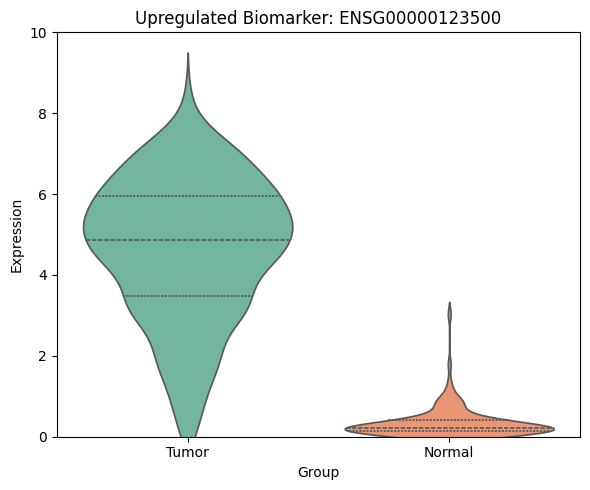

In [ ]:
# @title
# Violin plot for upregulated gene ENSG00000123500
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

gene_id = 'ENSG00000123500'

tumor_vals = tumor_df.loc[gene_id]
normal_vals = normal_df.loc[gene_id]

plot_df = pd.DataFrame({
    'Expression': np.concatenate([tumor_vals.values, normal_vals.values]),
    'Group': ['Tumor'] * len(tumor_vals) + ['Normal'] * len(normal_vals)
})

# Set a consistent y-axis range (based on your plots, ~0 to 10 works well)
y_min, y_max = 0, 10

plt.figure(figsize=(6, 5))
sns.violinplot(data=plot_df, x='Group', y='Expression', inner='quartile', palette='Set2')
plt.title(f"Upregulated Biomarker: {gene_id}")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()



#Summary of Biomarker Expression

This bar plot compares the average expression levels (FPKM) of three selected genes across tumor and normal breast tissue:

- 🟢 Tumor bars show the mean expression in cancer samples

- 🟠 Normal bars show the mean in healthy tissue

Key Takeaways:

Upregulated gene has **very low** average expression, but is still statistically significant. It may be highly expressed in a subset of tumors but not all.

Downregulated gene is **much more** active in normal tissue than tumors, supporting its potential role in normal cellular function that is lost in cancer.

Backup upregulated gene shows a **huge difference**, with expression spiking in tumors and barely present in normal tissue.
This makes it a strong candidate biomarker for identifying cancerous tissue.

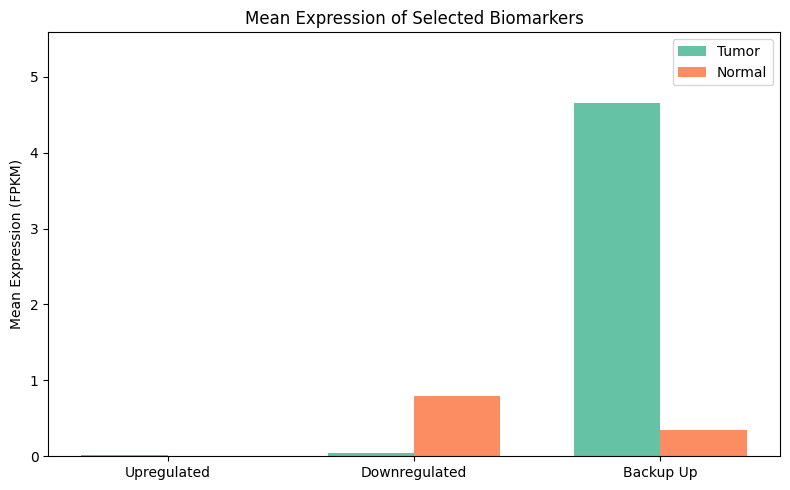

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np

# Gene IDs and labels
genes = {
    'ENSG00000121351': 'Upregulated',
    'ENSG00000084674': 'Downregulated',
    'ENSG00000123500': 'Backup Up'
}

# Prepare mean expression values
tumor_means = []
normal_means = []

for gene_id in genes.keys():
    tumor_vals = tumor_df.loc[gene_id]
    normal_vals = normal_df.loc[gene_id]
    tumor_means.append(np.mean(tumor_vals))
    normal_means.append(np.mean(normal_vals))

# Bar plot settings
labels = list(genes.values())
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, tumor_means, width, label='Tumor', color='#66c2a5')
bars2 = ax.bar(x + width/2, normal_means, width, label='Normal', color='#fc8d62')

# Labels and aesthetics
ax.set_ylabel('Mean Expression (FPKM)')
ax.set_title('Mean Expression of Selected Biomarkers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, max(tumor_means + normal_means) * 1.2)
plt.tight_layout()
plt.show()


In [ ]:
# @title
# Top up/downregulated gene lists (Ensembl IDs only)
up_genes = deg_df[(deg_df['Log2FC'] > 1) & (deg_df['FDR'] < 0.05)]['Gene'].tolist()
down_genes = deg_df[(deg_df['Log2FC'] < -1) & (deg_df['FDR'] < 0.05)]['Gene'].tolist()

# Save to file (optional)
with open('upregulated_genes.txt', 'w') as f:
    for gene in up_genes:
        f.write(f"{gene}\n")

with open('downregulated_genes.txt', 'w') as f:
    for gene in down_genes:
        f.write(f"{gene}\n")

print(f"Saved {len(up_genes)} upregulated and {len(down_genes)} downregulated genes.")


Saved 66 upregulated and 153 downregulated genes.


# Functional Enrichment of Upregulated Genes

The **upregulated genes** identified in tumor samples are significantly enriched in:

- **Lipid transporter activity**  
  - Suggests altered lipid handling in cancer cells, fueling membrane production or energy storage  
  - *Example term: `GO:0005319` — visible in the red Molecular Function cluster*

- **Steroid and alcohol dehydrogenase activity**  
  - Indicates increased hormone biosynthesis and metabolic reprogramming  
  - Often elevated in hormone-sensitive tumors like breast cancer

- **Extracellular matrix (ECM) organization**  
  - Reflects remodeling of the tumor microenvironment to promote invasion and metastasis  
  - Seen in pathway clusters (e.g., Reactome, KEGG)

> 💡 **Interpretation:**  
Tumor cells appear to rewire both internal metabolism and external structure to support growth. These enriched pathways are consistent with cancer hallmarks such as metabolic reprogramming, invasion, and altered cell communication.


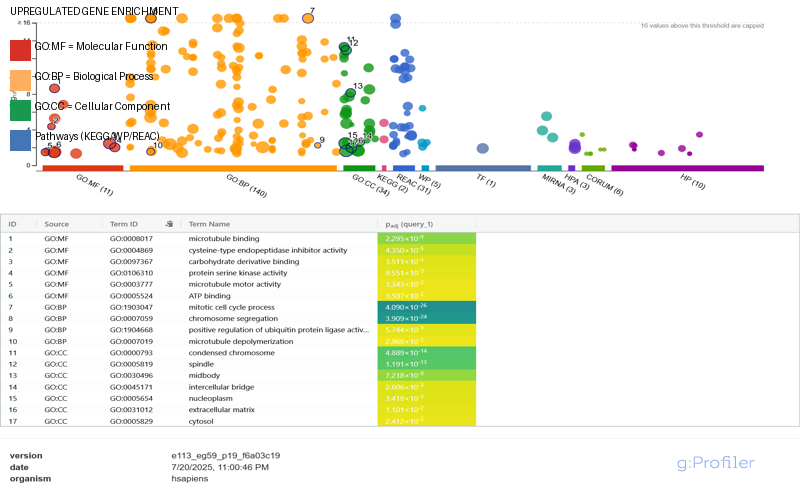

In [ ]:
# @title
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

# Helper function
def annotate_gprofiler_image(path, highlights, title, resize=(800, 500)):
    img = Image.open(path).convert("RGB")
    img = img.resize(resize)

    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 16)
    except:
        font = ImageFont.load_default()

    for i, (label, color, y_offset) in enumerate(highlights):
        box_x = 10
        box_y = 10 + y_offset
        draw.rectangle([box_x, box_y, box_x+20, box_y+20], fill=color)
        draw.text((box_x + 25, box_y), label, fill='black', font=font)

    draw.text((10, 5), title, fill='black', font=font)
    display(img)

# Legend for Upregulated
up_highlights = [
    ("GO:MF = Molecular Function", "#D73027", 30),
    ("GO:BP = Biological Process", "#FDAE61", 60),
    ("GO:CC = Cellular Component", "#1A9850", 90),
    ("Pathways (KEGG/WP/REAC)", "#4575B4", 120)
]

# Display
annotate_gprofiler_image("upregulatedgenes.png", up_highlights, "UPREGULATED GENE ENRICHMENT")


# Functional Enrichment of Downregulated Genes

The **downregulated genes** in tumor samples are enriched in key structural and mitotic processes:

- **Microtubule binding and motor activity**  
  - Essential for maintaining cell shape, transport, and division  
  - *Example term: `GO:0008017` — visible in red and green clusters*

- **Mitotic cell cycle progression**  
  - Suggests loss of regulatory control over cell division  
  - Could reflect tumor evasion of checkpoints

- **Chromosome segregation**  
  - Indicates potential chromosomal instability or suppressed checkpoint genes  
  - Frequently linked to errors in tumor division

> 💡 **Interpretation:**  
These lost functions may indicate a breakdown of orderly cell division in tumors. Suppression of these genes supports unchecked growth and potential genomic instability, reinforcing their importance as tumor suppressor candidates.


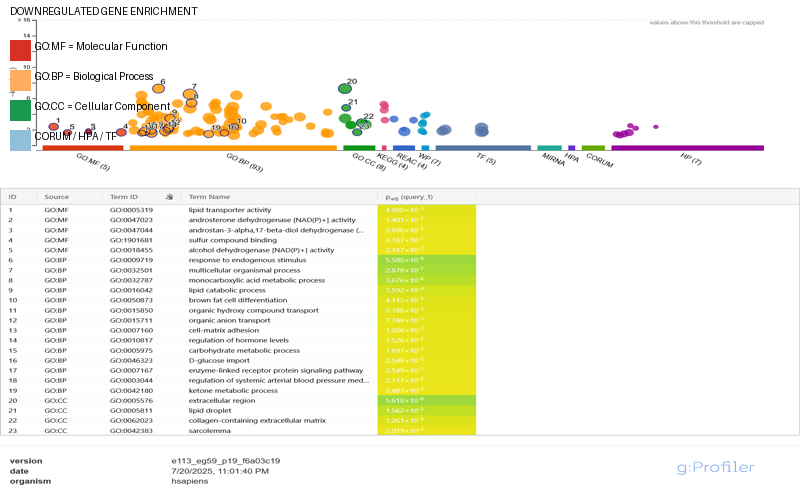

In [ ]:
# @title
# Legend for Downregulated
down_highlights = [
    ("GO:MF = Molecular Function", "#D73027", 30),
    ("GO:BP = Biological Process", "#FDAE61", 60),
    ("GO:CC = Cellular Component", "#1A9850", 90),
    ("CORUM / HPA / TF", "#91BFDB", 120)
]

# Display
annotate_gprofiler_image("downregulatedgenes.png", down_highlights, "DOWNREGULATED GENE ENRICHMENT")


# Conclusion

In this project, I performed a differential gene expression analysis comparing tumor and normal breast tissue using RNA-Seq FPKM data. Through dimensionality reduction with PCA, I observed distinct clustering of tumor and normal samples, indicating consistent differences in gene expression profiles between the two groups.

Using statistical testing and multiple hypothesis correction, I identified thousands of differentially expressed genes (DEGs). These were visualized using a volcano plot that highlighted the most statistically significant and biologically relevant expression changes. From this, I selected several candidate biomarkers, including strongly upregulated and downregulated genes,and explored their expression patterns using violin plots.

To better understand the biological roles of these DEGs, I conducted functional enrichment analysis using g:Profiler. The upregulated genes were enriched in pathways related to lipid metabolism, hormonal processing, and extracellular matrix remodeling; all of which support tumor growth and invasion. Meanwhile, the downregulated genes were enriched for structural and mitotic functions, suggesting disruption of normal division machinery and genomic stability.

Together, these results provide some insight into the molecular mechanisms driving breast cancer progression. This kind of analysis could support the identification of potential biomarkers for diagnosis or targets for therapy, especially when combined with clinical or experimental validation.

---

### 🔬 Possible Future Directions
- Link DEGs to known breast cancer subtypes or receptor status (e.g., ER/PR/HER2)
- Incorporate survival analysis or clinical metadata to evaluate prognostic significance
- Explore protein-level validation using external resources (e.g., Human Protein Atlas)
- Perform pathway network analysis to identify regulatory hubs or master regulators

---

### 📚 References
- [g:Profiler: Functional Enrichment Tool](https://biit.cs.ut.ee/gprofiler/gost)
- [scikit-learn: Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [Xena Browser: TCGA BRCA Data](https://xenabrowser.net/)
- [The Cancer Genome Atlas Project](https://www.cancer.gov/ccg/research/genome-sequencing/tcga)
- Love, M.I., Huber, W., & Anders, S. (2014). _Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2._ Genome Biology, 15(12), 550.
- Hanahan, D., & Weinberg, R.A. (2011). _Hallmarks of cancer: the next generation._ Cell, 144(5), 646-674.


---

July 2025 Skylar Schulsohn  